In [1]:
# Follow the link below:
# https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
# https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

import psycopg2
import nltk
import pandas as pd
import numpy as np
import re
import string

In [4]:
# importing and creating df (has to have type_id)

# usage: specify file location, sample size and seed(used by random) 
filepath = '/home/daniel/Downloads/clean-100k.csv'                           # Linux
filepath = 'd:/Personal/Desktop/downloads-tmp/clean-100k.csv'                # win
filepath = 'd:/Personal/OneDrive/KU-uni/DataScience/Python/small.csv'        # win small
filepath = '/home/daniel/OneDrive/KU-uni/DataScience/Python/small.csv' # Linux small
s = 250                    # desired sample size(seems to have slack ie. not exact)
seed = 1                     # seed used by Pseudorandom number generator

df = pd.read_csv(filepath, index_col = [0]).sample(n=s, random_state=seed)
df["content"] = df["content"].astype(str)
# create type_id
df['type_id'] = df.groupby(['type']).ngroup()

df.head()

,Unnamed: 0.1,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,content_tokens,type_id
67,67,11593,washingtonexaminer.com,political,http://www.washingtonexaminer.com/us-support-f...,The United States has slashed its contribution...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,US support for UNRWA has gone on long enough,Michael Rubin,NaN,"['Blog Contributors', 'Refugees', 'Palestinian...","When the U.N. created UNRWA, it was meant to b...",NaN,NaN,[],6
249,249,39558,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/bill-clinton...,Former U.S. President Bill Clinton on Monday c...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Bill Clinton Calls for Release of Reuters Jour...,NaN,NaN,"['bill clinton', 'myanmar', 'calls', 'release'...",Former U.S. President Bill Clinton Calls for R...,"Donald Trump, Russia, Trump Administration, Gu...",NaN,[],-1
230,230,37351,beforeitsnews.com,fake,http://beforeitsnews.com/alternative/2018/01/t...,The Real Story Behind Marijuana Prohibition\n\...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,The Real Story Behind Marijuana Prohibition,The Daily Sheeple,NaN,[''],NaN,NaN,NaN,[],3
161,161,25191,beforeitsnews.com,fake,http://beforeitsnews.com/health/2017/04/audio-...,Audio Sensors Market Analysis by Current Indus...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Audio Sensors Market Analysis by Current Indus...,NaN,NaN,[''],NaN,NaN,NaN,[],3
91,91,15468,beforeitsnews.com,fake,http://beforeitsnews.com/science-and-technolog...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Yawning — Why Is It So Contagious and Why Shou...,Alton Parrish,NaN,[''],NaN,NaN,NaN,[],3


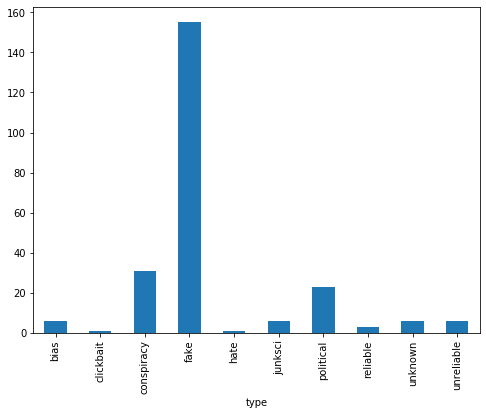

In [5]:
# plotting of categories

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('type').content.count().plot.bar(ylim=0)
plt.show()

In [6]:
# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# print information about data
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 250 Rows, 18 Columns


Column,Unnamed: 0.1,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,content_tokens,type_id
Unique,250,250,29,11,250,239,2,1,1,248,110,1,36,52,25,1,1,11
Missing,0,0,0,12,0,0,0,0,0,0,80,250,0,196,223,250,0,0


### Dataset Preparation

In [7]:
# working with content as a series
series_content = df['content']

### preprocessing - https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing ###
# try creating super regex ie. combine alle into one - might be alot faster

### replace [name] with tokens in text ###

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
series_content = series_content.replace(to_replace=regexURL, value='<URL>', regex=True)

# replace emails with token
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
series_content = series_content.replace(to_replace=regexEmail, value='<EMAIL>', regex=True)

# replace dates with token
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
series_content = series_content.replace(to_replace=regexDate, value='<DATE>', regex=True)

# replace numbers with token
regexNum = r"[0-9][0-9,\.]+" # type of nums with [0-9] and [,.]
series_content = series_content.replace(to_replace=regexNum, value='<NUM>', regex=True)

### remove chars in text ###
# repalc "\n"
regexNL = r"(\\n)"
series_content = series_content.replace(to_replace=regexNL, value=' ', regex=True) # inserts space instead of removing pt.

# remove punctuations - remove "<" and ">"
regexPunkt = r"[!“”\"#$%&()*+,\-–.\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means it's -> its - remove \' from regex if not needed
series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)
print("->", series_content.iloc[0])

# lower Casing - IMP lower casing is DONE my most of the modern day vecotirzers and tokenizers 
series_content = series_content.str.lower()

# remove stopwords - NOT DONE
stopWords = set(stopwords.words('english'))
series_content.str.split().explode().isin(stopWords) == False



-> The United States has slashed its contribution to the UN Relief and Works Agency for Palestinian refugees by more than NUM million but still gave the agency NUM million Thats NUM million too much UNRWA has become the poster child for UN bureaucratic bloat mission creep and twisted morality

UNRWA was founded in NUM to help Palestinian refugees displaced by Israels war of independence Even that decision was questionable After all putting Israels creation aside in the NUMs alone wars created more than NUM million refugees There was World War II of course but the NUM partition of India also displaced NUM million persons and created millions of refugees In the wake of Israels creation Arab states expelled hundreds of thousands of their Jews This is why the UN created the United Nations High Commissioner for Refugees to be the permanent agency charged with refugee assistance and protection

Individual Palestinian Arab families suffered dislocation and tragedy but they were hardly alone T

NameError: name 'stopwords' is not defined

In [36]:
series_content

67     the united states has slashed its contribution...
249    former us president bill clinton on monday cal...
230    the real story behind marijuana prohibition\n\...
161    audio sensors market analysis by current indus...
91     headline bitcoin  blockchain searches exceed t...
                             ...                        
137    headline bitcoin  blockchain searches exceed t...
72     a weird week draws to a close\n\nheadline bitc...
140    how to easily understand the difference betwee...
235    error\n\nmain error mesage here\n\nmore detail...
37     greg hunter big banks in big trouble syrianort...
Name: content, Length: 250, dtype: object

Common data cleaning steps
- make text all lower case
- remove puntuiation
- remove numerical values
- remove common non-sensial text(/n)
- tokanize text



In [31]:
# working with content as a series
series_content = df['content']

### Defining functions for cleaning
### some functions cant be ron before others
### CANT BE AFTER = CBA - meaning it negates the given functions

### overall preprocessing
# lower_cast - Maybe not needed - lower casing is DONE my most of the modern day vecotirzers and tokenizers
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (lower_cast)"); series_content = series_content.replace(to_replace=regexEmail, value='<EMAIL>', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (lower_cast)"); series_content = series_content.replace(to_replace=regexHTML, value='<HTML>', regex=True)

# Date_replace
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (lower_cast)"); series_content = series_content.replace(to_replace=regexDate, value='<DATE>', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # type of nums with [0-9] and [,.]
series_content = series_content.replace(to_replace=regexNum, value='<NUM>', regex=True)

### string removal functions
# End_of_line_remove
regexNL = r"(\\n)"
%time print("\n (lower_cast)"); series_content = series_content.replace(to_replace=regexNL, value=' ', regex=True)

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regex if not needed
series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

def remove_stopwords(text): # words like 'the', 'a', 'me' - SLOW
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])








# execute and time - comment out to NOT run
# forma: %time print(func_name) series=func(series)


%time print("\n (lower_cast)");     series_content = lower_cast     (series_content)

%time print("\n (Email_replace)");      series_content = Email_replace  (series_content)
%time print("\n (URL_replace)");        series_content = URL_replace    (series_content)
%time print("\n (HTML_replace)");       series_content = URL_replace    (series_content)
%time print("\n (Date_replace)");       series_content = Date_replace   (series_content)
%time print("\n (End_of_line_remove)"); series_content = Number_replace (End_of_line_remove)
%time print("\n (Number_replace)");     series_content = Number_replace (series_content)


# %time print("\n (End_of_line_remove)");     series_content = End_of_line_remove (series_content)

print("\n (Done cleaning)")
# series_content.iloc[1]


 (lower_cast)
CPU times: user 5.51 ms, sys: 0 ns, total: 5.51 ms
Wall time: 5.26 ms

 (lower_cast)
CPU times: user 31 ms, sys: 3.22 ms, total: 34.2 ms
Wall time: 33.5 ms

 (lower_cast)
CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 1.25 ms

 (lower_cast)
CPU times: user 213 ms, sys: 0 ns, total: 213 ms
Wall time: 213 ms

 (lower_cast)
CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 1.36 ms

 (lower_cast)
CPU times: user 6.7 ms, sys: 0 ns, total: 6.7 ms
Wall time: 6.45 ms

 (Email_replace)
CPU times: user 37.8 ms, sys: 0 ns, total: 37.8 ms
Wall time: 37.7 ms

 (URL_replace)
CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 105 ms

 (HTML_replace)
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 108 ms

 (Date_replace)
CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 227 ms

 (End_of_line_remove)


AttributeError: 'function' object has no attribute 'replace'

In [13]:
series_content.iloc[3]

'audio sensors market analysis by current industry status & growth opportunities, top key players, target audience and forecast to <NUM>\n\n% of readers think this story is fact. add your two cents.\n\nheadline: bitcoin & blockchain searches exceed trump! blockchain stocks are next!\n\naudio sensors market is expected to witness growth of international market with respect to advancements and innovations including development history, competitive analysis and regional development forecast.\n\nthe report starts with a basic audio sensors market overview. in this introductory section, the research report incorporates analysis of definitions, classifications, applications and industry chain structure.\n\nin depth analysis of audio sensors market is a crucial thing for various stakeholders like investors, ceos, traders, suppliers and others.\n\nbrowse more detail information about audio sensors market at: <URL>\n\nto begin with, the report elaborates the audio sensors market overview. vario

In [100]:
# series_content[series_content['content'].apply(regexDate)]

df1 =series_content.str.extract(r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*").isnull()

In [106]:
df1['mask'] = series_content.str.contains('(\d+[A-Z]+\d+)')


In [113]:
pat = r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
df_bool = series_content.str.contains(pat)

In [117]:
result = pd.DataFrame(series_content.str.extract(r'([\d]+)',expand=False))


In [67]:
from time import perf_counter 
t1_start = perf_counter()  
# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
series_content = series_content.replace(to_replace=regexURL, value='<URL>', regex=True)

# Stop the stopwatch / counter 
t1_stop = perf_counter() 
  
print("Elapsed time:", t1_stop, t1_start)  

Elapsed time: 7556.248846449 7554.760254202


In [70]:
import time
 
class MeasureDuration:
    def __init__(self):
        self.start = None
        self.end = None
 
    def __enter__(self):
        self.start = time.time()
        return self
 
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.time()
        print("Total time taken: %s" % self.duration())
 
    def duration(self):
        return str((self.end - self.start) * 1000) + ' milliseconds'

In [1]:
from time import time

class Timer():
    def __init__(self, message):
        self.message = message
    def __enter__(self):
        self.start = time()
        return None  # could return anything, to be used like this: with Timer("Message") as value:
    def __exit__(self, type, value, traceback):
        elapsed_time = (time() - self.start) * 1000
        print(self.message.format(elapsed_time))

In [46]:
df = pd.DataFrame({'x': [1, 2, 3, 4], 'y': [5, 6, 7, 8]})

# runs on single core
df['x2'] = df['x'].apply(lambda x: x**2)
# runs on multiple cores
df['x2'] = df['x'].swifter.apply(lambda x: x**2)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.type_id
features.shape

(5000, 39001)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['type_id'], df['content'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)clf = MultinomialNB().fit(X_train_tfidf, y_train)

SyntaxError: invalid syntax (<ipython-input-8-8ae1abe34dc4>, line 10)

In [ ]:
def remove_stopwords(text): # words like 'the', 'a', 'me' - SLOW
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# def lower_cast(series_in): # Maybe not needed - lower casing is DONE my most of the modern day vecotirzers and tokenizers
#     """Lower Casing"""
#     return series_in.str.lower()

# def Email_replace(series_in):
#     """Replace emails with token"""
#     regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
#     return series_in.replace(to_replace=regexEmail, value='<EMAIL>', regex=True)

# def HTML_replace(series_in):
#     """REpalce HTML wiith token"""
#     regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
#     return series_in.replace(to_replace=regexHTML, value='<HTML>', regex=True)

# def Date_replace(series_in): # NOT WORKING PROBABLY - needs to be recreated
#     """Replace dates with token"""
#     # name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
#     # day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
#     # year         ([12][0-9]{3})         - Years from 1000 to 2999
#     regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
#     return series_in.replace(to_replace=regexDate, value='<DATE>', regex=True)

# def Number_replace(series_in): 
#     """Replace numbers with token"""
#     regexNum = r"[0-9][0-9,\.]+" # type of nums with [0-9] and [,.]
#     return series_in.replace(to_replace=regexNum, value='<NUM>', regex=True)

# def End_of_line_remove(series_in):
#     """Remove end_of_line \n"""
#     regexNL = r"(\\n)"
#     return series_in.replace(to_replace=regexNL, value=' ', regex=True)

# def Punctuation_remove(series_in): 
#     """Remove punctuations"""
#     regexPunkt = r"[!“”\"#$%&()*+,\-–.\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regex if not needed
#     series_in.replace(to_replace=regexPunkt, value='', regex=True)
